In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms 
from torch.utils.data import DataLoader,Subset
import numpy as np
from torch import nn
import math
import torch.nn.functional as F
import torchvision.datasets as datasets

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [2]:
transform = transforms.Compose([
    transforms.Resize(28),                 # (MNIST is already 28x28; crop not needed)
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),       # FIX: train in [-1,1] for DDPM stability
])

data=datasets.MNIST(root="C:/Users/maddo/Downloads/COdes from Work/Working on now",train=True,download=True,transform=transform)

In [3]:
# data = datasets.CelebA(root="C:/Users/maddo/Downloads/COdes from Work/Working on now",split='train',target_type='attr',download=True,transform=transform)

In [4]:
len(data)

60000

In [5]:
train_loader=DataLoader(data,batch_size=32, shuffle=True)

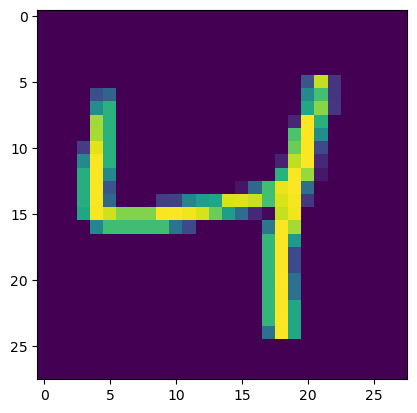

In [6]:

plt.imshow(data[2][0].permute(1,2,0))

In [7]:
T=300
beta = torch.linspace(1e-4, 0.046,T)
alpha = 1.0 - beta
alphacum = torch.cumprod(alpha, dim=0) 
sqrtalphacum=torch.sqrt(alphacum)
minsqrtalphacum=torch.sqrt(1-alphacum)
alphacum_prev = torch.cat([torch.tensor([1.0]), alphacum[:-1]], dim=0) 

In [8]:
def make_cosine_beta(T, s=0.008, device=None):
    steps = torch.arange(T+1, dtype=torch.float32, device=device)
    f = torch.cos(((steps / T + s) / (1 + s)) * torch.pi / 2) ** 2
    alpha_bar = f / f[0]                     # ᾱ_t
    betas = 1.0 - (alpha_bar[1:] / alpha_bar[:-1])
    return betas.clamp(1e-5, 0.999)

In [9]:
device='cuda'

In [10]:


beta = make_cosine_beta(T, device=device)
alpha = 1.0 - beta
alphacum = torch.cumprod(alpha, dim=0)
sqrtalphacum = torch.sqrt(alphacum)
minsqrtalphacum = torch.sqrt(1 - alphacum)
alphacum_prev = torch.cat([torch.tensor([1.0], device=device), alphacum[:-1]], dim=0)

print('alpha_cum_end =', float(alphacum[-1])) 

alpha_cum_end = 2.698518741794942e-08


In [11]:
ind=0

In [12]:
def noisyimagetest(img,timestep,eps):
    mul=sqrtalphacum[timestep].to('cuda')
    epsmul=minsqrtalphacum[timestep].to('cuda')
    print(mul)
    mul = mul[:, None, None, None]
    epsmul = epsmul[:, None, None, None]
    img=img.to('cuda')
    eps=eps.to('cuda')
    noisy=(img*mul+eps*epsmul).to('cuda')
    plt.subplot(4,1,1)
    plt.figsize=(10,19)
    plt.imshow(noisy[0].to('cpu').permute(1,2,0))
    plt.subplot(4,1,2)
    plt.imshow(noisy[1].to('cpu').permute(1,2,0))
    plt.subplot(4,1,3)
    plt.imshow(noisy[3].to('cpu').permute(1,2,0))
    plt.subplot(4,1,4)
    plt.imshow(noisy[4].to('cpu').permute(1,2,0))
    
    #return noisy
    

In [13]:
def noisyimage(img, timestep, eps):
    # img: (B,1,28,28), timestep: (B,), eps: like img
    mul    = sqrtalphacum.to(img.device)[timestep]       # FIX: ensure same device
    epsmul = minsqrtalphacum.to(img.device)[timestep]    # FIX: ensure same device
    mul    = mul[:, None, None, None]
    epsmul = epsmul[:, None, None, None]
    noisy  = img * mul + eps * epsmul
    return noisy

tensor([0.9998, 0.9997, 0.9997, 0.9997, 0.9998, 0.9998, 0.9998, 0.9997, 0.9997,
        0.9997, 0.9998, 0.9998, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997,
        0.9997, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997, 0.9998, 0.9997,
        0.9997, 0.9997, 0.9997, 0.9998, 0.9998], device='cuda:0')
tensor([0.9998, 0.9997, 0.9997, 0.9997, 0.9998, 0.9998, 0.9998, 0.9997, 0.9997,
        0.9997, 0.9998, 0.9998, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997,
        0.9997, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997, 0.9998, 0.9997,
        0.9997, 0.9997, 0.9997, 0.9998, 0.9998], device='cuda:0')
tensor([0.9998, 0.9997, 0.9997, 0.9997, 0.9998, 0.9998, 0.9998, 0.9997, 0.9997,
        0.9997, 0.9998, 0.9998, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997,
        0.9997, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997, 0.9998, 0.9997,
        0.9997, 0.9997, 0.9997, 0.9998, 0.9998], device='cuda:0')


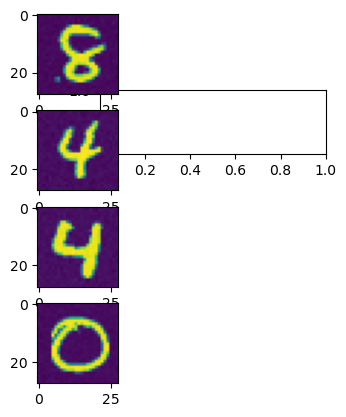

In [14]:
for x,_ in train_loader:
    times=torch.randint(1,3,(len(x),))
    eps=torch.randn_like(x)
    #print(eps.shape)
    plt.subplot(5,2,4)
    noisyimagetest(x,times,eps)
    noisyimagetest(x,times,eps)
    noisyimagetest(x,times,eps)
    break

In [15]:
def extract(a, t, x_shape):
    """
    Take a 1D tensor a of length T, pick entries at indices t (B,), and reshape for broadcast to x_shape.
    """
    b = t.shape[0]
    out = a.gather(0, t).reshape(b, *([1] * (len(x_shape) - 1)))
    return out

In [16]:
def timestep_embedding(t, dim=64, max_period=10000):
    # t in [0, T-1] integer or float; returns (B, dim)
    if t.dtype != torch.float32:
        t = t.float()
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(0, half, device=t.device).float() / half
    )  # (half,)
    args = t[:, None] * freqs[None, :]  # (B, half)
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=1)
    if dim % 2:  # odd
        emb = F.pad(emb, (0,1))
    return emb

In [17]:
class noisepredict(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()
        in_dim = 28*28
        self.time_mlp = nn.Sequential(
            nn.Linear(emb_dim, 128), nn.SiLU(),
            nn.Linear(128, 128)
        )
        self.fc1  = nn.Linear(in_dim + 128, 512)
        self.fc2  = nn.Linear(512, 512)
        self.fc3  = nn.Linear(512, in_dim)
        self.act  = nn.SiLU()
    def forward(self, x, t):
        b = x.size(0)
        x = x.view(b, -1)
        t_norm = t.view(b) / (alphacum.shape[0] - 1) * (alphacum.shape[0] - 1)  # keep scale ~ original indices
        temb = self.time_mlp(timestep_embedding(t_norm, dim=64))
        x = torch.cat([x, temb], dim=1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x.view(b, 1, 28, 28)

In [18]:
enc=noisepredict()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc = enc.to(device)

In [20]:
optim = torch.optim.AdamW(enc.parameters(), lr=2e-4, betas=(0.9, 0.999), weight_decay=0.0)
criterion = nn.MSELoss()

In [21]:
epoch=600

In [23]:
for i in range(epoch):
    oneofus=0
    enc.train()
    ma = 0.0
    count = 0
    for x,_ in train_loader:
        times=torch.randint(0,T,(len(x),)).to(device)
        eps=torch.randn(len(x),1,28,28).to(device)
        x=x.to(device)
        x_time=noisyimage(x,times,eps)
        pred=enc(x_time,times)
        optim.zero_grad()
        loss=criterion(pred,eps)
        #print(loss.item())
        loss.backward()
        optim.step()
        oneofus=loss.item()
        count += 1
        ma += (loss.item() - ma) / count
    if i%2==0:
        print(f" For Epoch number {i} Loss is currently {ma}")#
        
        

        
        
    

 For Epoch number 0 Loss is currently 0.4716914819558459


KeyboardInterrupt: 

In [26]:
@torch.no_grad()
def sample(model, x_t, t):
    """
    Runs the full DDPM reverse process from T-1 -> 0.
    Keeps your original signature; `t` is ignored beyond batch sizing.
    Provide x_t as pure noise of shape (B,1,28,28).
    """
    model.eval()
    x_t = x_t.to(device)
    B = x_t.size(0)

    for step in reversed(range(T)):                      # FULL chain
        t_long = torch.full((B,), step, dtype=torch.long, device=x_t.device)

        # Gather scalars (B,1,1,1)
        alpha_t        = alpha.to(x_t.device)[t_long].view(B,1,1,1)
        alpha_hat_t    = alphacum.to(x_t.device)[t_long].view(B,1,1,1)
        beta_t         = beta.to(x_t.device)[t_long].view(B,1,1,1)
        alpha_hat_prev = alphacum_prev.to(x_t.device)[t_long].view(B,1,1,1)

        # Predict noise
        eps = model(x_t, t_long)

        # DDPM mean
        mean = (x_t - ((1.0 - alpha_t) / torch.sqrt(1.0 - alpha_hat_t)) * eps) / torch.sqrt(alpha_t)

        # DDPM variance
        var   = (1.0 - alpha_hat_prev) / (1.0 - alpha_hat_t) * beta_t
        sigma = torch.sqrt(torch.clamp(var, min=1e-20))

        # No noise at t=0
        z = torch.randn_like(x_t)
        nonzero = (t_long > 0).float().view(B,1,1,1)
        x_t = mean + nonzero * sigma * z

    # map [-1,1] -> [0,1] for viewing
    out = x_t.clamp(-1, 1)
    out = (out + 1) / 2.0
    print(out.shape)   # (B,1,28,28)
    plt.imshow(out[0, 0].detach().cpu())
    plt.axis('off')
    return out

for _ in range(2):
    newsamples = torch.randn(6, 3, 64, 64)
    tsamples   = torch.full((newsamples.size(0),), 1, dtype=torch.long)  # (B,) long
    sample(enc, newsamples, tsamples)

torch.Size([6, 1, 28, 28])
torch.Size([6, 1, 28, 28])


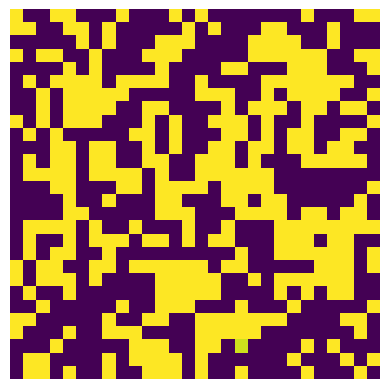

In [27]:
for _ in range(2):
    newsamples = torch.randn(6, 1, 28, 28, device=device)                      # start from noise
    tsamples   = torch.full((newsamples.size(0),), T-1, dtype=torch.long, device=device)
    sample(enc, newsamples, tsamples)    